# Assembling the GSFLOW model

So far, two models, watershed model and groundwater model, are generated but are not connected. In this notebook, we will demonstrate how these two model can be connected to form the GSFLOW model. Note: To successfully run this exercise make sure to provide the correct paths for the PRMS folder and MODFLOW folder.

### Outline
* Assemble GSFLOW model from PRMS and MODFLOW
* Run the model and visualize the ouputs.


<img src = ".\figures\WorkFlow.png">


In [1]:
import os
from gsflow import GsflowModel
import flopy
import matplotlib.pyplot as plt
import pandas
import numpy as np
flopy.__version__

flopy is installed in c:\users\jlarsen\desktop\flopy-dev\flopy


'3.3.1'

### (1) Load the PRMS model using pyGSFLOW
Notice that loaded control file has a "PRMS" mode.

In [2]:
control_file = r"./data/sagehen/prms/windows/sagehen.control"
gs = GsflowModel.load_from_file(control_file)

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\sagehen\prms\input\calibration_parameters.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\sagehen\prms\input\cascade.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\sagehen\prms\input\default_values.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\sagehen\prms\input\gis_derived_parameters.param
------------------------------------
PRMS model loaded ...
Mode is set to PRMS only, loading PRMS model only


### (2) Load Modflow using pygsflow

pygsflow has a special module that loads Modflow models using FloPy, but corrects for loading and file writing issues specific to GSFLOW

In [3]:
from gsflow.modflow import Modflow

mf = Modflow.load(r"./data/sagehen/modflow/saghen.nam")

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:


### (3) Add Modflow object to pyGSFLOW

In [4]:
print(mf.get_package_list())
gs.mf = mf

['DIS', 'BAS6', 'UPW', 'SFR', 'OC', 'UZF', 'NWT']


### (4) Change model mode and  synchronize PRMS and MODFLOW times

In [5]:
gs.control.set_values(name="model_mode", values=['GSFLOW'])
gs.control.set_values(name="start_time", values=[1982, 8, 1, 0, 0, 0])
gs.control.set_values(name='end_time', values=[1997, 3, 31, 0, 0, 0])
gs.control.set_values(name='modflow_time_zero', values=[1982, 8, 1, 0, 0, 0])
gs.control.set_values(name='print_debug', values = [1])

c:\users\jlarsen\desktop\usgs-pygsflow-r-0.2.0\trunk\gsflow\param_base.py:125: UserWarning: The record does not exist modflow_time_zero
  warnings.warn(err, UserWarning)


### (5) Generate GSFLOW input files in the desired workspace.  

In [6]:
gs.write_input(workspace=r"./data/temp", basename='saghen_new')

Writing the project files .....

changing model workspace...
   C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\temp
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Modflow files...


In [7]:
gs.gsflow_exe = os.path.abspath(r"../bin/gsflow.exe")


### Running GSFLOW will take about 5 minutes....

In [8]:
gs.run_model()

pyGSFLOW is using the following executable to run the model: C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\bin\gsflow.exe

(base) C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\temp>C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\bin\gsflow.exe C:\Users\jlarsen\Desktop\usgs-pygsflow-r-0.2.0\trunk\examples\data\temp\saghen_new_cont.control 


                          U.S. Geological Survey
        Coupled Groundwater and Surface-water FLOW model (GSFLOW)
                         Version 1.2.2 02/23/2018

    An integration of the Precipitation-Runoff Modeling System (PRMS)
    and the Modular Groundwater Model (MODFLOW-NWT and MODFLOW-2005)


                               MODFLOW-NWT 
  U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                         WITH NEWTON FORMULATION
                         VERSION 1.1.3, 8/01/2017 
              BASED ON MODFLOW-2005 VERSION 1.11.0 08/08/2013

 WARNING, map_results requested with

(True, [])

# Results Visualization

* GSFLOW budget: Dailey flow rates from/to all the integrated hydrologic model compartments. 
* PRMS output: PRMS Water-Budget, Statistic Variables, and PRMS Animation Variables. 
* Modflow outputs (heads & budget)


### GSFLOW basin budget. 
GSFLOW saves the dialey flow rates (and volumes) for all the integrated hydrologic model compartments. The results are saved in a Comma-separated values (CSV) file, which can efficiently imported and visualized using Pandas.

In [9]:
# The filename can be found in the control object under the name "csv_output_file"
workspace = r"./data/temp"
csv_file = gs.control.get_values("csv_output_file")[0]

# Import results into Pandas
basin_bd = pandas.read_csv(os.path.join(workspace, csv_file))

# Show the first 10 lines of the budget in the notebook
basin_bd.head(10)

,Date,StreamOut_Q,HortSroff2Stream_Q,DunnSroff2Stream_Q,Interflow2Stream_Q,Stream2Unsat_Q,StreamExchng2Sat_Q,Canopy_S,SnowPweqv_S,Imperv_S,...,LakeEvap_Q,DunnInterflow2Lake_Q,HortSroff2Lake_Q,Lake2Unsat_Q,LakeExchng2Sat_Q,SoilDrainage2Unsat_Q,Sat2Grav_Q,RechargeUnsat2Sat_Q,Infil2Soil_Q,KKITER
0,08/01/1982,10040.370,0.000000,340.359100,0.000000e+00,0.0,-9700.099,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13758.67,22125.51,0.00,5
1,08/02/1982,9683.263,0.000000,0.111282,0.000000e+00,0.0,-9671.305,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13694.57,22045.38,0.00,1
2,08/03/1982,9978.035,0.000000,330.086900,0.000000e+00,0.0,-9637.533,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13643.74,21945.16,0.00,1
3,08/04/1982,9941.550,0.000000,321.213700,0.000000e+00,0.0,-9610.348,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13597.96,21854.42,0.00,1
4,08/05/1982,9908.570,0.000000,313.505600,-4.790259e-08,0.0,-9585.466,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13556.73,21756.69,0.00,1
5,08/06/1982,9878.247,0.000000,306.767700,6.605501e-02,0.0,-9562.053,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13519.27,21648.44,0.00,1
6,08/07/1982,9869.150,0.000000,300.846300,1.338024e+00,0.0,-9559.488,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.034307,13485.05,21551.72,0.00,1
7,08/08/1982,10206.670,0.071366,559.383300,2.497055e+02,0.0,-9534.492,16128.06,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.299104,13454.67,21456.07,21441.81,1
8,08/09/1982,10016.510,0.000000,796.341200,2.180476e+02,0.0,-9508.984,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.572187,13427.88,21373.33,0.00,1
9,08/10/1982,10488.420,0.000000,768.927100,2.729306e+02,0.0,-9477.723,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.988039,13406.14,21293.14,0.00,1


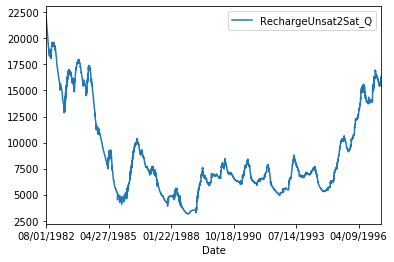

In [10]:
# To demonstrate plotting a budget component, let us plot the daily recharge values
basin_bd.plot(x='Date', y = 'RechargeUnsat2Sat_Q')

Importing the budget into Pandas allows us to access all of the powerful built in operations that come with Pandas

For example, let's plot the annual precipitation

In [11]:
basin_bd['Date'] = pandas.to_datetime(basin_bd['Date'])
Budget_by_year = basin_bd.groupby(basin_bd.Date.dt.year).sum()


Text(0.5, 1.0, 'Annual Stream Outflow')

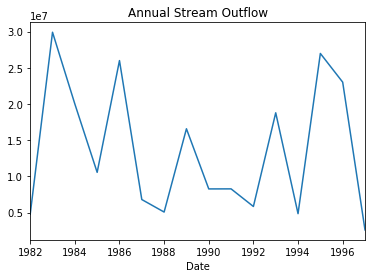

In [12]:
Budget_by_year['StreamOut_Q'].plot() ; plt.title("Annual Stream Outflow")

Text(0.5, 1.0, 'Monthly Stream Outflow')

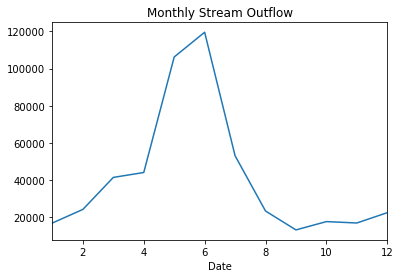

In [13]:
Budget_by_month = basin_bd.groupby(basin_bd.Date.dt.month).mean()
Budget_by_month['StreamOut_Q'].plot(); plt.title("Monthly Stream Outflow")

### PRMS Statistic Variables
This following method can be used to import statVar file into Pandas.

In [14]:
# Load the results
gs.prms.get_StatVar()

Loading the statvar output file .....
Finished Load the statvar output file .....


,ID,Year,Month,Day,Hour,Minute,Second,basin_cfs_1,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_dunnian_1,basin_ssflow_cfs_1,basin_ppt_1,basin_snow_1,basin_pweqv_1,basin_snowcov_1,basin_actet_1,basin_potsw_1,basin_recharge_1,Date
0,1,1982,8,1,0,0,0,4.103844,-3.964766,0.139117,0.000487,0.000000,0.000000,0.000000,0.000000,0.000000,0.020947,680.605620,0.000000,1982-08-01
1,2,1982,8,2,0,0,0,3.957884,-3.952997,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012704,649.570046,0.000000,1982-08-02
2,3,1982,8,3,0,0,0,4.078368,-3.939193,0.134918,0.000472,0.000000,0.000000,0.000000,0.000000,0.000000,0.014409,611.057569,0.000000,1982-08-03
3,4,1982,8,4,0,0,0,4.063455,-3.928081,0.131291,0.000459,0.000000,0.000000,0.000000,0.000000,0.000000,0.015524,629.305791,0.000004,1982-08-04
4,5,1982,8,5,0,0,0,4.049975,-3.917911,0.128141,0.000448,-0.000000,0.000000,0.000000,0.000000,0.000000,0.017163,671.293030,0.000027,1982-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5352,5353,1997,3,27,0,0,0,34.220159,-2.336412,16.826881,0.058777,14.719215,0.000000,0.000000,18.083924,0.891914,0.059704,525.456266,0.048083,1997-03-27
5353,5354,1997,3,28,0,0,0,35.477745,-2.347604,17.800707,0.062186,15.501201,0.000000,0.000000,17.805016,0.881564,0.056646,510.869867,0.050114,1997-03-28
5354,5355,1997,3,29,0,0,0,23.338710,-2.459326,8.651543,0.030212,11.556364,0.000000,0.000000,17.629650,0.871146,0.043759,518.188000,0.050969,1997-03-29
5355,5356,1997,3,30,0,0,0,30.275589,-2.427277,12.749356,0.044529,14.838732,0.012579,0.007007,17.445031,0.962941,0.034635,525.355649,0.051610,1997-03-30


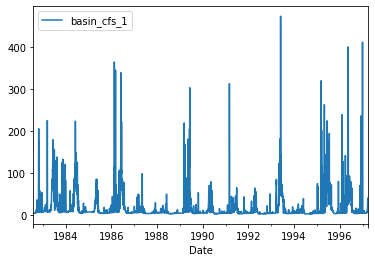

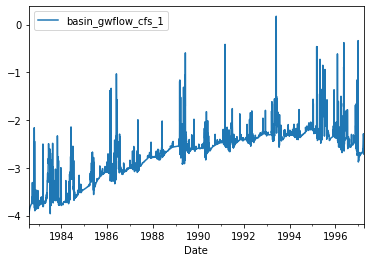

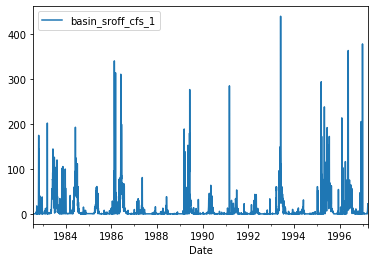

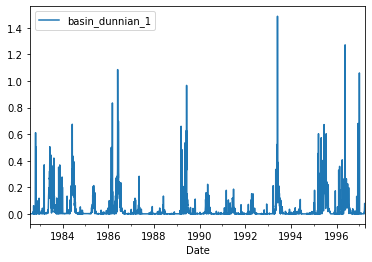

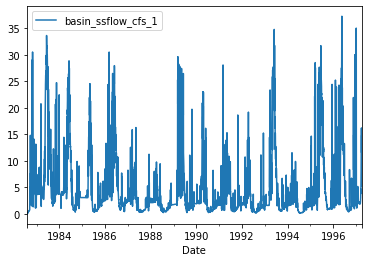

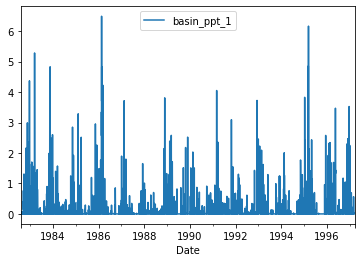

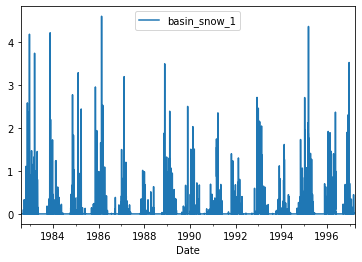

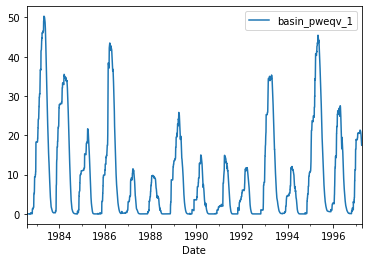

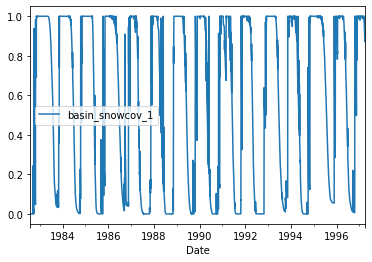

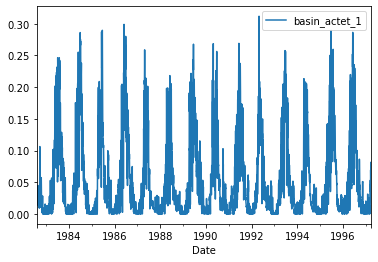

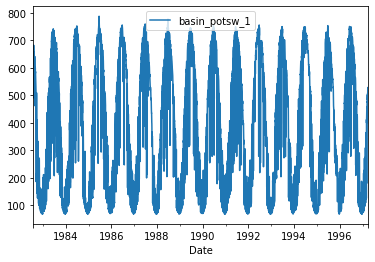

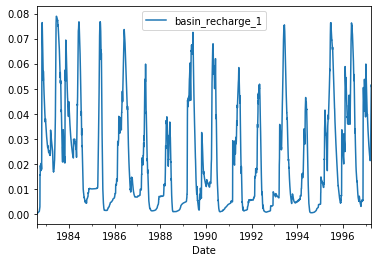

In [15]:
# To plot all results, we can use the following method...
gs.prms.stat.plot()

In [16]:
## Importing the animation is not supported yet. In the future, a method will be added to generate vedio from animation file.

# MODFLOW Results

In [17]:
mf = gs.mf
mf

MODFLOW 2 layer(s) 77 row(s) 84 column(s) 2 stress period(s)

### Hydraulic Head Maps

In [18]:
# List Modflow output files
mf.output_fnames

['saghen_new.cbc',
 'saghen_new.sfr.out',
 'saghen_new.hds',
 'saghen_new.UZF.cbc']

In [19]:
# Obtain heads output file name
head_file = os.path.join(mf.model_ws, mf.output_fnames[2])
head_file

cbc = os.path.join(mf.model_ws, mf.output_fnames[0])

In [20]:
# load the head into the hds object
hds = flopy.utils.HeadFile(head_file)
cbc = flopy.utils.CellBudgetFile(cbc)

In [21]:
# Since the head is saved at different time points, we first need to fid these times
print(cbc.textlist)
fff = cbc.get_data(text="FLOW FRONT FACE", full3D=True)[-1]
frf = cbc.get_data(text="FLOW RIGHT FACE", full3D=True)[-1]
flf = cbc.get_data(text="FLOW LOWER FACE", full3D=True)[-1]
# hds.get_kstpkper()

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'  STREAM LEAKAGE', b'         STORAGE']


In [22]:
# To get the data at any time point, 
head = hds.get_data(kstpkper= (729, 1))
head[head<0] = np.nan

(0.0, 83.0, 76.0, 0.0)

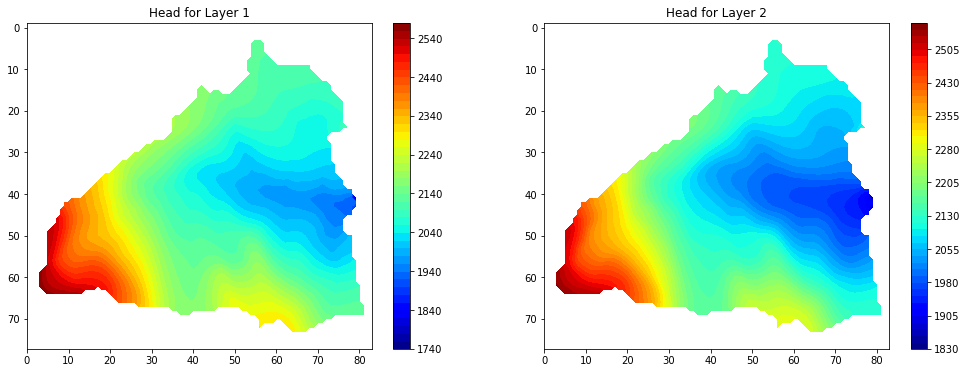

In [23]:
# Now we can plot the head map
plt.figure(figsize=(17,6));
plt.subplot(1,2,1)
plt.contourf(head[0,:,:],50, cmap = 'jet');plt.gca().invert_yaxis(); plt.colorbar(); plt.title("Head for Layer 1")
plt.axis('equal')
plt.subplot(1,2,2)
plt.contourf(head[1,:,:],50, cmap = 'jet');plt.gca().invert_yaxis(); plt.colorbar(); plt.title("Head for Layer 2")
plt.axis('equal')

## Head Cross-section

c:\users\jlarsen\desktop\flopy-dev\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


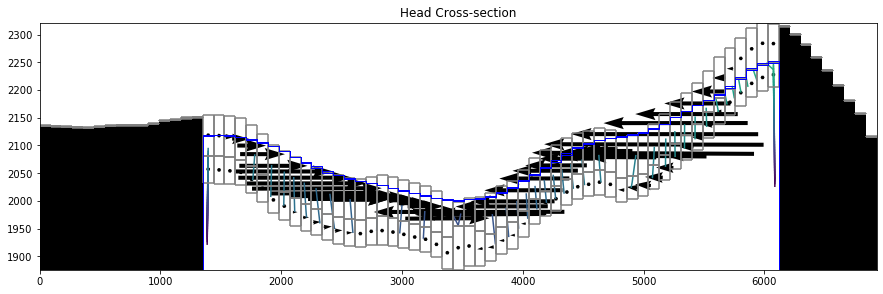

In [24]:
head = hds.get_data()
levels = np.arange(1830, 2505, 10)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('Head Cross-section')
modelxsect = flopy.plot.ModelCrossSection(model=mf, line={'Column': 50})
ct = modelxsect.contour_array(head, masked_values=[999.], head=head, levels=levels)
patches = modelxsect.plot_ibound(head=head)
wt = modelxsect.plot_surface(head, masked_values=[999.], color='blue', lw=1)
linecollection = modelxsect.plot_grid()
disc = modelxsect.plot_discharge(frf, fff, flf)

### Heads Timeseries
Sometimes we are interested more in a head change with time at a certain point...

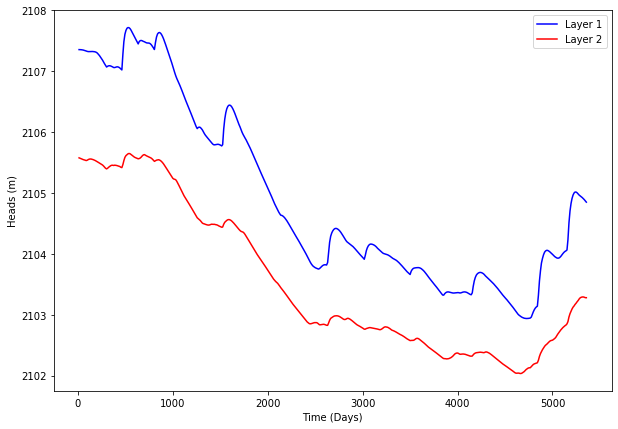

In [25]:
plt.figure(figsize=(10,7)); 

# The point should be specified as  (layer, row, column)
point = (0,50,50)

# Extract time series at this point
h_ts = hds.get_ts(idx=point)
plt.plot(h_ts[2:,0], h_ts[2:,1], 'b', label = "Layer 1")


# let us do the same thing for the second layer and compare the results ...
point = (1,50,50)
h_ts = hds.get_ts(idx=point)
plt.plot(h_ts[2:,0], h_ts[2:,1], 'r', label = "Layer 2")
plt.xlabel("Time (Days)")
plt.ylabel("Heads (m)")
plt.legend()

### Modflow Budget 

In [26]:
# Obtain heads output file name
cbc_file = os.path.join(mf.model_ws, mf.output_fnames[0])
cbc_file

'C:\\Users\\jlarsen\\Desktop\\usgs-pygsflow-r-0.2.0\\trunk\\examples\\data\\temp\\saghen_new.cbc'

In [27]:
# Load Budget
cbc = flopy.utils.CellBudgetFile(cbc_file)

In [28]:
# list the time points where budget result is available
cbc.get_kstpkper()

[(0, 0),
 (0, 1),
 (10, 1),
 (21, 1),
 (32, 1),
 (42, 1),
 (53, 1),
 (64, 1),
 (75, 1),
 (85, 1),
 (96, 1),
 (107, 1),
 (118, 1),
 (128, 1),
 (139, 1),
 (150, 1),
 (160, 1),
 (171, 1),
 (182, 1),
 (193, 1),
 (203, 1),
 (214, 1),
 (225, 1),
 (236, 1),
 (246, 1),
 (257, 1),
 (268, 1),
 (279, 1),
 (289, 1),
 (300, 1),
 (311, 1),
 (321, 1),
 (332, 1),
 (343, 1),
 (354, 1),
 (364, 1),
 (375, 1),
 (386, 1),
 (397, 1),
 (407, 1),
 (418, 1),
 (429, 1),
 (439, 1),
 (450, 1),
 (461, 1),
 (472, 1),
 (482, 1),
 (493, 1),
 (504, 1),
 (515, 1),
 (525, 1),
 (536, 1),
 (547, 1),
 (558, 1),
 (568, 1),
 (579, 1),
 (590, 1),
 (600, 1),
 (611, 1),
 (622, 1),
 (633, 1),
 (643, 1),
 (654, 1),
 (665, 1),
 (676, 1),
 (686, 1),
 (697, 1),
 (708, 1),
 (719, 1),
 (729, 1),
 (740, 1),
 (751, 1),
 (761, 1),
 (772, 1),
 (783, 1),
 (794, 1),
 (804, 1),
 (815, 1),
 (826, 1),
 (837, 1),
 (847, 1),
 (858, 1),
 (869, 1),
 (879, 1),
 (890, 1),
 (901, 1),
 (912, 1),
 (922, 1),
 (933, 1),
 (944, 1),
 (955, 1),
 (965, 1),
 

In [29]:
# list budget items that exist in the budget file
cbc.textlist

[b'   CONSTANT HEAD',
 b'FLOW RIGHT FACE ',
 b'FLOW FRONT FACE ',
 b'FLOW LOWER FACE ',
 b'  STREAM LEAKAGE',
 b'         STORAGE']

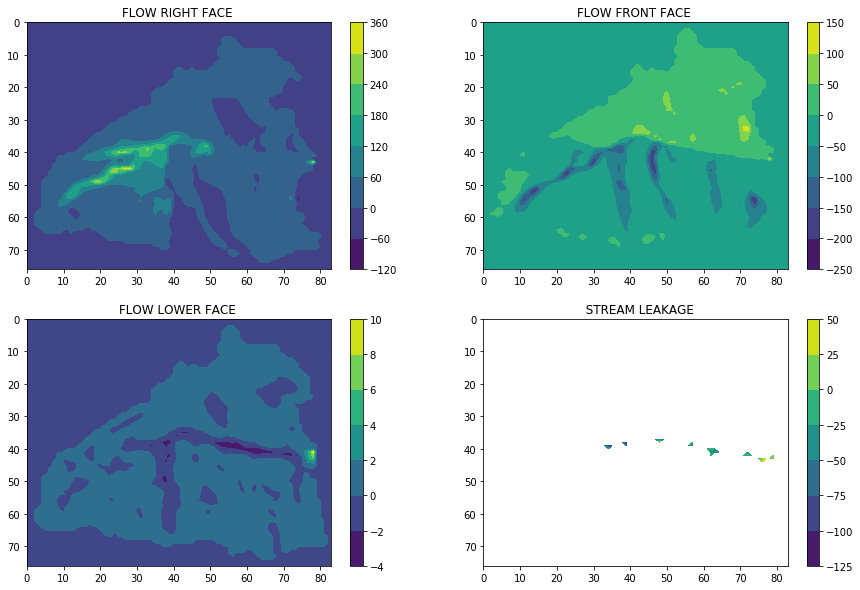

c:\users\jlarsen\desktop\flopy-dev\flopy\plot\map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


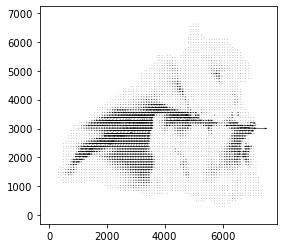

In [30]:
## Plot 
plt.figure(figsize=(15,10)); 
frf = cbc.get_data(full3D=True, kstpkper= (5355, 1),text='FLOW RIGHT FACE ')
plt.subplot(2,2,1)
plt.contourf(frf[0][0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('FLOW RIGHT FACE ')

fff = cbc.get_data(full3D=True, kstpkper= (5355, 1),text= 'FLOW FRONT FACE ')
plt.subplot(2,2,2)
plt.contourf(fff[0][0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('FLOW FRONT FACE ')


flf = cbc.get_data(full3D=True, kstpkper= (5355, 1),text= 'FLOW LOWER FACE ')
plt.subplot(2,2,3)
plt.contourf(flf[0][0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('FLOW LOWER FACE ')


xx = cbc.get_data(full3D=True, kstpkper= (5355, 1),text=   '  STREAM LEAKAGE' )
plt.subplot(2,2,4)
plt.contourf(xx[0][0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('  STREAM LEAKAGE')
plt.show()

mm = flopy.plot.ModelMap(model=mf, layer=0)
mm.plot_discharge(frf[0], flf[0], istep=1, jstep=1)

### Reading information from the list file

In [31]:
list_file = mf.name + ".list"
list_file

'C:\\Users\\jlarsen\\Desktop\\usgs-pygsflow-r-0.2.0\\trunk\\examples\\data\\temp\\saghen_new.list'

In [32]:
mf_list = flopy.utils.MfListBudget(list_file)
incrementaldf, cumulativedf = mf_list.get_dataframes()

In [33]:
incrementaldf

,STORAGE_IN,CONSTANT_HEAD_IN,STREAM_LEAKAGE_IN,UZF_RECHARGE_IN,GW_ET_IN,SURFACE_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,STREAM_LEAKAGE_OUT,UZF_RECHARGE_OUT,GW_ET_OUT,SURFACE_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.000000,136.334503,569.261230,23918.714844,0.0,0.0,24624.310547,0.000000,546.925110,9950.185547,0.0,0.0,14108.366211,24605.476562,18.834000,0.08
1970-01-03,1744.514038,136.335007,545.275696,22125.498047,0.0,0.0,24551.623047,0.031873,546.918823,10245.374023,0.0,0.0,13758.672852,24550.996094,0.627000,0.00
1970-01-13,1976.814331,136.353607,536.964417,21216.029297,0.0,0.0,23866.162109,0.007653,546.687500,9997.451172,0.0,0.0,13382.004883,23926.152344,-59.990200,-0.25
1970-01-24,2370.832275,136.417404,548.540588,20384.693359,0.0,0.0,23440.484375,0.041569,545.957703,9873.343750,0.0,0.0,13190.116211,23609.458984,-168.974594,-0.72
1970-02-04,2811.242188,136.540207,559.975708,19621.847656,0.0,0.0,23129.607422,0.486400,544.932373,9796.375000,0.0,0.0,13051.747070,23393.539062,-263.931610,-1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984-07-20,1628.758057,148.669693,937.729004,15950.421875,0.0,0.0,18665.578125,3661.350098,486.626709,7559.363770,0.0,0.0,6281.083984,17988.423828,677.154297,3.69
1984-07-30,1633.552979,148.735001,941.974670,15670.723633,0.0,0.0,18394.986328,3478.194336,486.456207,7526.721680,0.0,0.0,6283.313477,17774.685547,620.300781,3.43
1984-08-10,1651.851440,148.805893,949.202515,15489.699219,0.0,0.0,18239.560547,3377.431396,486.260712,7495.933594,0.0,0.0,6284.550293,17644.175781,595.384827,3.32
1984-08-21,1612.105225,148.876602,958.164673,15517.625000,0.0,0.0,18236.771484,3561.627197,486.082306,7270.604004,0.0,0.0,6363.407715,17681.720703,555.050781,3.09


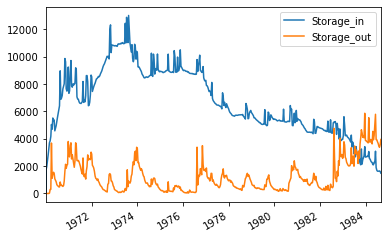

In [34]:
incrementaldf['STORAGE_IN'].plot(label = 'Storage_in')
incrementaldf['STORAGE_OUT'].plot(label = 'Storage_out')
plt.legend()

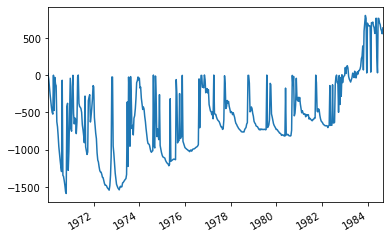

In [35]:
incrementaldf['IN-OUT'].plot()

In [36]:
!jupyter nbconvert --to script Assemble_GSFLOW_model.ipynb

This application is used to convert notebook files (*.ipynb) to various other
formats.


Options

-------



Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.


--debug

    set log level to logging.DEBUG (maximize logging output)

--generate-config

    generate default config file

-y

    Answer yes to any questions instead of prompting.

--execute

    Execute the notebook prior to export.

--allow-errors

    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.

--stdin

    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'

--stdout

    Write notebook output to stdout instead of files.

--inplace

    Run nbconvert in 

[NbConvertApp] WARNING | pattern 'Assemble_GSFLOW_model.ipynb' matched no files
